<a href="https://colab.research.google.com/github/CodeHunterOfficial/Data-Mining/blob/main/01.LinearModels/Lecture_1_1_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Регуляризация

Прежде чем рассмотреть регуляторы, давайте рассмотрим, что такое **переобучение (overfitting)** и **дообучение (fine-tuning)**.

**Дообучение (fine-tuning)**: Это процесс, при котором модель, уже обученная на определенных данных, дополнительно обучается на новых данных для улучшения своей производительности или адаптации к новой задаче. Дообучение позволяет модели лучше обобщать знания, полученные на предыдущем этапе обучения. Оно возникает, когда модель слишком точно подстраивается под обучающие данные и начинает выдавать плохие результаты на новых данных. Например, если модель для задачи классификации избыточно запоминает каждый пример обучающей выборки, не улавливая общие закономерности, то она может переобучиться и показывать плохие результаты на тестовых данных.

**Переобучение (overfitting)**: Это явление, когда модель слишком точно подстраивается под обучающие данные и теряет способность обобщать на новые данные. В результате модель может показывать отличные результаты на обучающих данных, но плохо справляться с новыми, ранее не виденными примерами. Оно возникает, когда уже обученная модель дополнительно обучается на новых данных или для новой задачи. Например, предварительно обученная нейронная сеть для распознавания изображений на большом наборе данных может быть дообучена на небольшом наборе данных для распознавания конкретных классов.

## Сложность модели

__Сложность модели__ (*model complexity*) — важный гиперпараметр. В частности, для линейных моделей сложность может быть представлена количеством параметров, например, для полиномиальных моделей — степенью полинома.

Сложность модели тесно связана с __ошибкой обобщения__ (_generalization error_). Ошибка обобщения отличается от ошибки обучения, измеряемой на тренировочных данных, тем, что позволяет оценить обобщающую способность модели, приобретенную в процессе обучения, давать точные ответы на неизвестных ей объектах. Cлишком простой модели не будет хватать количества параметров для обобщения сложной закономерности в данных, что приведёт к большой ошибке обобщения. С другой стороны, избыточная сложность модель также приводит к большой ошибке обобщения за счет того, что в силу своей сложности модель начинает пытаться искать закономерности в шуме, добиваясь большей точности на тренировочных данных, теряя при этом часть обобщающей способности.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/model_complexity.png" width="500">

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/l2_regularization.png" width="300">

Параметры модели задают некоторую **аппроксимацию целевой функции**. Аппроксимировать целевую функцию можно несколькими способами, например:
1. Использовать все имеющиеся данные и провести ее строго **через все точки**, которые нам известны ($f1$ на картинке);
2. Использовать более простую функцию (в данном случае, линейную), которая не попадет точно во все данные, но зато будет соответствовать некоторым **общим закономерностям**, которые у них есть ($f2$ на картинке).

Характерной чертой переобучения является первый сценарий, и сопровождается он, как правило, **большими весами**.

Проиллюстрируем описанное явление на примере полиномиальной модели:

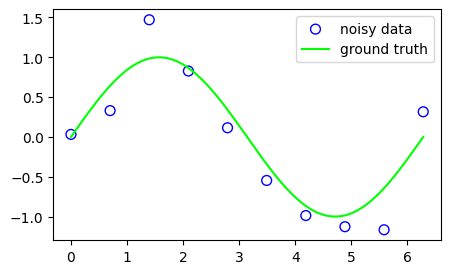

In [ ]:
x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x) + np.random.normal(scale=0.25, size=len(x))
x_true = np.linspace(0, 2 * np.pi, 200)
y_true = np.sin(x_true)

plt.figure(figsize=(5, 3))
plt.scatter(x, y, s=50, facecolors="none", edgecolors="b", label="noisy data")
plt.plot(x_true, y_true, c="lime", label="ground truth")
plt.legend()
plt.show()

Попробуем аппроксимировать имеющуюся зависимость с помощью полиномиальной модели, используя шумные данные в качестве тренировочных данных:

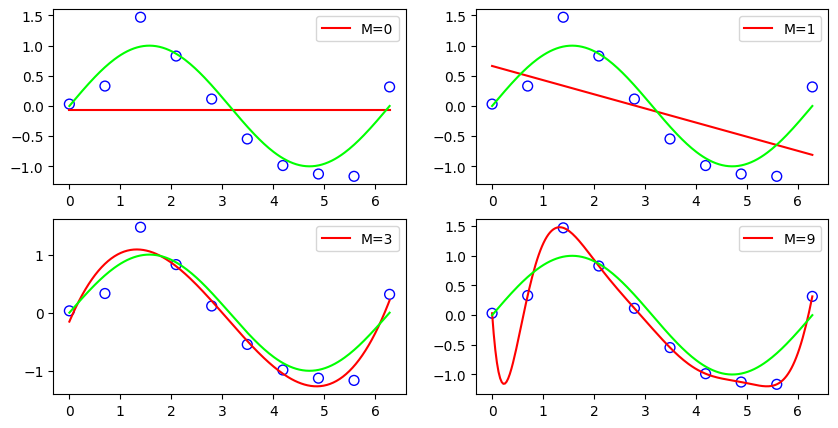

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

x_train = x.reshape(-1, 1)

fig = plt.figure(figsize=(10, 5))

for i, degree in enumerate([0, 1, 3, 9]):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    model.fit(x_train, y)
    y_plot = model.predict(x_true.reshape(-1, 1))

    fig.add_subplot(2, 2, i + 1)
    plt.plot(x_true, y_plot, c="red", label=f"M={degree}")
    plt.scatter(x, y, s=50, facecolors="none", edgecolors="b")
    plt.plot(x_true, y_true, c="lime")
    plt.legend()
plt.show()

Видно, что модель может переобучаться, подстраиваясь под тренировочную выборку. В полиноме степень, и, как следствие, количество весов — это гиперпараметр, который можно подбирать на кросс-валидации, однако когда мы таким образом подбираем сложность модели, мы накладываем довольно грубое ограничение на обобщающую способность модели в целом. Вместо этого более разумным было бы оставить модель сложной, но использовать некий ограничитель (__регуляризатор__), который будет заставлять модель отдавать предпочтение выбору более простого обобщения.

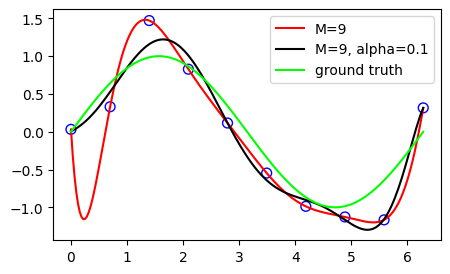

Without regularization:  y = 0.0+-12.11*x+39.41*x^2+-46.31*x^3+28.6*x^4+-10.48*x^5+2.35*x^6+-0.32*x^7+0.02*x^8+-0.0*x^9
With regularization:  y = 0.0+0.37*x+0.52*x^2+0.23*x^3+-0.19*x^4+-0.21*x^5+0.17*x^6+-0.04*x^7+0.01*x^8+-0.0*x^9


In [ ]:
from sklearn.linear_model import Ridge

model = make_pipeline(PolynomialFeatures(9), LinearRegression())
model_ridge = make_pipeline(PolynomialFeatures(9), Ridge(alpha=0.1))

model.fit(x_train, y)
y_plot = model.predict(x_true.reshape(-1, 1))

model_ridge.fit(x_train, y)
y_plot_ridge = model_ridge.predict(x_true.reshape(-1, 1))

plt.figure(figsize=(5, 3))
plt.plot(x_true, y_plot, c="red", label=f"M={degree}")
plt.plot(x_true, y_plot_ridge, c="black", label=f"M={degree}, alpha=0.1")
plt.scatter(x, y, s=50, facecolors="none", edgecolors="b")
plt.plot(x_true, y_true, c="lime", label="ground truth")
plt.legend()
plt.show()

poly_coef = model[1].coef_

eq = f"y = {round(poly_coef[0], 2)}+{round(poly_coef[1], 2)}*x"
for i in range(2, 10):
    eq += f"+{round(poly_coef[i], 2)}*x^{i}"

print("Without regularization: ", eq)

poly_coef = model_ridge[1].coef_

eq = f"y = {round(poly_coef[0], 2)}+{round(poly_coef[1], 2)}*x"
for i in range(2, 10):
    eq += f"+{round(poly_coef[i], 2)}*x^{i}"

print("With regularization: ", eq)

Видно, что одним из "симптомов" переобучения являются аномально большие веса.


## Необходимость регуляризации
В отличие от аппроксимации полиномом, трудно представить, как линейная регрессия может переобучить данные, поскольку это всего лишь одна линия (или гиперплоскость). Одна из ситуаций заключается в том, что функции коррелируют или избыточны.

Предположим, есть два объекта, оба абсолютно одинаковые, наша прогнозируемая гиперплоскость будет в этом формате:
$$
\hat{y} = w_0 + w_1x_1 + w_2x_2
$$

и истинные ценности $x_2$ почти то же самое, что $x_1$
(или с некоторым мультипликативным коэффициентом и шумом). Тогда лучше просто бросить $w_2 x_2$
термин и использование:

$$\hat {y}=w_0+w_1x_1$$
чтобы соответствовать данным. Это более простая модель.

Но мы не знаем,$x_1$ и $x_2$
на самом деле является избыточным или нет, по крайней мере, на первый взгляд, и мы не хотим вручную удалять параметр только потому, что нам так хочется. Мы хотим, чтобы модель научилась делать это сама, то есть предпочитать более простую модель, которая достаточно хорошо соответствует данным .



Для решения этих задач используем регуляризацию. Рассмотрим, как регуляризация может улучшить вашу регрессию. Продемонстрируем эффект регуляризации на примере и увидим, что чем больше регуляризации мы добавляем (фактор $α$), тем меньше становятся веса $w$.

Для простоты мы не будем использовать какие-либо конкретные пакеты ML, вместо этого мы обучаем простую модель линейной регрессии в векторной форме:


In [ ]:
import numpy as np

# Определяем матрицу признаков X размером 6x3 с почти одинаковыми вторым и третьим столбцами
X = np.array([[4, 4, 4],
              [3, 5, 5],
              [5, 1, 1],
              [5, 4, 4],
              [7, 5, 5],
              [4, 5, 5.00000001]])

# Определяем вектор y размером 1x6
y = np.array([1, 2, 3, 1, 2, 3])

# Вычисляем матрицу Грама для X
XTX = X.T.dot(X)
print(XTX)

# Находим обратную матрицу для матрицы Грама
XTX_inv = np.linalg.inv(XTX)
print(XTX_inv)

# Вычисляем вектор весов w:
w = XTX_inv.dot(X.T).dot(y)
print(w)

[[140.         111.         111.00000004]
 [111.         108.         108.00000005]
 [111.00000004 108.00000005 108.0000001 ]]


LinAlgError: Singular matrix

Эта ошибка возникает, когда матрица является сингулярной, то есть ее определитель равен нулю. В таком случае обратная матрица не существует или вычисления невозможны. Необходимо проверить данные или применить соответствующие методы для работы с сингулярными матрицами.

Давайте теперь используем LinearRegression.

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Определяем матрицу признаков X размером 6x3 с почти одинаковыми вторым и третьим столбцами
X = np.array([[4, 4, 4],
              [3, 5, 5],
              [5, 1, 1],
              [5, 4, 4],
              [7, 5, 5],
              [4, 5, 5.00000001]])

# Определяем вектор y размером 1x6
y = np.array([1, 2, 3, 1, 2, 3])

# Создаем объект LinearRegression и обучаем модель
model = LinearRegression().fit(X, y)

# Выводим коэффициенты модели (веса)
print(model.coef_)

[ 8.42105295e-02 -1.62105261e+08  1.62105260e+08]


Как видно, второе и третье значения вектора весов w огромны. Это происходит из-за того, что исходная матрица признаков X содержит почти одинаковые столбцы: 2 и 3.

Давайте введем регуляризацию и посмотрим, как изменится вектор w.

In [ ]:
# Добавляем регуляризационный коэффициент 0.01 к главной диагонали матрицы Грама
XTX = XTX + 0.01 * np.eye(3)
print(XTX)

# Находим обратную матрицу для матрицы Грама
XTX_inv = np.linalg.inv(XTX)
print(XTX_inv)

# Вычисляем вектор весов w:
w = XTX_inv.dot(X.T).dot(y)
print(w)

[[140.01       111.         111.00000004]
 [111.         108.01       108.00000005]
 [111.00000004 108.00000005 108.0100001 ]]
[[ 3.85624712e-02 -1.98159300e-02 -1.98158861e-02]
 [-1.98159300e-02  5.00124975e+01 -4.99875026e+01]
 [-1.98158861e-02 -4.99875026e+01  5.00124974e+01]]
[0.33643484 0.04007035 0.04007161]


## Штраф $L_2$ и $L_1$
0. Без штрафа (или линейного)
Это линейная регрессия без какой-либо регуляризации (из предыдущей лукции ):

$$E(w)=\frac{1}{2} \cdot \sum_{i=1}^{N} (t_i - w^T \phi(x_i))^2$$


Для предотвращения переобучения в модели линейной регрессии добавляем новое слагаемое в целевую функцию. В общем виде оно имеет следующий вид:

$$ J(w) = \text{MSE} + \alpha \sum_{j=1}^{M-1} |w_j|^q  $$

Где:
- $J(w)$ - функция потерь с регуляризацией
- MSE - среднеквадратичная ошибка
- $w_j$ - i-й коэффициент модели
- $ M $ - количество признаков
- $\alpha$ - параметр регуляризации, контролирующий силу штрафа
- $q$ - параметр, определяющий соотношение между L1 и L2 регуляризацией. То есть, если $q=2$, то получается L2 (Ridge), а когда $q=1$, получается L1 (Lasso).

Существуют два основных типа регуляризации в линейной регрессии:
- L1 (Lasso) регуляризация способствует разреженности модели, устанавливая некоторые веса признаков в ноль, что позволяет проводить отбор признаков.
- L2 (Ridge) регуляризация штрафует большие значения всех весов, не обнуляя их, что помогает бороться с мультиколлинеарностью и повышает обобщающую способность модели.

### Штраф L2 (или Ридж)
Модель Ridge Regression, показанная в примере выше, использует L2-регуляризацию для борьбы с этим явлением:

$$E(w) = \frac{1}{2} \cdot \sum_{i=1}^{N} (t_i - w^T \phi(x_i))^2 + \frac{λ}{2}\sum_{j=1}^{M-1} |w_j|^2  $$

где $α=\frac{λ}{2}.$


Это называется штрафом $L_2$ только потому, что это $L_2$-норма вектора весов $w$. Говоря простым языком, вся эта функция потерь также известна как регрессия Риджа.

Давайте посмотрим, что происходит. Функция потерь – это то, что мы минимизируем. Любые термины, которые мы добавляем к ней, мы также хотим свести к минимуму (вот почему это называется штрафным членом). Вышеупомянутое означает, что мы хотим, чтобы веса $w$  хорошо соответствовали данным (первый член), но нам также нужно, чтобы значения весов были как можно меньше (второй член). Лямбда $\lambda$ дает возможность регулировать сумму штрафа на веса. Обратите внимание, что в библиотеке scikit-learn это называется альфа $\alpha$ вместо этого, но это несущественно.

Сложно найти подходящее значение для $\lambda$. Вам просто нужно опробовать их в экспоненциальном диапазоне (0.01, 0.1, 1, 10 и т. д.), а затем выбрать то значение, которое дает наименьшие потери на проверочном наборе данных или выполнить кросс-валидацию.

Низкое значение параметра $\lambda$ означает, что мы не сильно наказываем сложную модель. Установка его на 0 соответствует исходной линейной регрессии. Установка высокого значения означает, что мы решительно предпочитаем более простую модель за счет того, насколько хорошо она соответствует данным.


Из линейной алгебры знаем, что если $ w = \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \end{bmatrix} $ - многомерный вектор размерности $ n \times 1 $, то транспонированный вектор $$ w^T = \begin{bmatrix} w_1 & w_2 & \cdots & w_n \end{bmatrix} $$ будет вектором-строкой размерности $ 1 \times n $.

Тогда $$ w^T \times w = \begin{bmatrix} w_1 & w_2 & \cdots & w_n \end{bmatrix} \times \begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \end{bmatrix} = w_1^2 + w_2^2 + \cdots + w_n^2=\sum_{i=1}^{N} w_i^2$$.

Таким образом,$ w^T \times w $ равно сумме квадратов элементов вектора $ w $, что представляет собой квадрат нормы (длины) вектора $ w $.

Тогда наша целевая функция $J(w)$  приметь вид:

$$ E(w) = \frac{1}{2} \cdot \sum_{i=1}^{N} (t_i - w^T \phi(x_i))^2 + \frac{λ}{2}w^T w $$





$$\frac{∂E}{∂w_j}=\frac{1}{2} \cdot \sum_{i=1}^{N} 2 \cdot (t_i - w^T \phi(x_i))\cdot (-\phi_j(x_i))  + \frac{λ}{2}2 \cdot w_j=  -\sum_{i=1}^{N} (t_i - w^T \phi(x_i))\cdot \phi_j(x_i)  + λ \cdot w_j$$

Тогда градиент:

$$∇_{w}E=-\sum_{i=1}^{N} (t_i -w^T \cdot \phi(x_i))\cdot \phi(x_i)  + λ \cdot w$$

тобы найти минимум функции ошибки, необходимо приравнять градиент функции к нулю. То есть, чтобы найти оптимальные веса модели в линейной регрессии с L2-регуляризацией, необходимо решить уравнение:

$$∇_{w}E = 0$$

где градиент функции ошибки равен нулю. Это позволит найти оптимальные значения весов модели, обеспечивающие минимум функции ошибки с учетом регуляризации.



Для упрощения вычислений и перехода от векторной формы уравнения к матричной форме, транспонирование обеих частей последнего уравнения.
После транспонирования обеих сторон уравнения $\nabla_{w}E = 0$, мы получаем:

$$\nabla_{w}E^T = O^T$$

Такой подход может помочь в анализе и решении уравнения для нахождения оптимальных весов модели в линейной регрессии с L2-регуляризацией.
$$O^T=-\sum_{i=1}^{N} (t_i -w^T \cdot \phi(x_i))\cdot \phi(x_i)^T  + λ \cdot w^T=-\sum_{i=1}^{N} t_i \cdot \phi(x_i)^T +w^T \sum_{i=1}^{N} \phi(x_i) \cdot \phi(x_i)^T  + λ \cdot w^T=-t^T Φ+w^T(Φ^TΦ+λI)$$

$$t^T Φ=w^T(Φ^TΦ+λI)$$
Отсюда
$$w^T=(Φ^TΦ+λI)^{-1} \cdot Φ t^T $$


$$w=((Φ^TΦ+λI)^{-1})^T \cdot (Φ t^T)^T $$

Из курса алгебры мы знаем, что:

Транспонированная сумма матриц  A и B равна сумме транспонированных матриц:

$$(A + B)^T = A^T + B^T$$

Следовательно

$$w=((Φ^TΦ)^T+λI^T)^{-1}) \cdot Φ^T t $$

$$w=(Φ^TΦ+λI)^{-1} \cdot Φ^T t $$

 Введение **L2-регуляризации** приводит к тому, что **большие веса больше штрафуются** и предпочтение отдается решениям, использующим **малые значения весов**. При этом модель будет **сохранять скоррелированные и неважные признаки с маленькими весами**.

Это связано с градиентом $L_2$:
$$L'_{2w_i} = 2\alpha w_i$$
Он будет “тянуть” модель в сторону маленьких весов.

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/l1_and_l2_regularization.gif" alt="alttext" width="550"/></center>

### Штраф L1 (или Lasso)
Модель Lasso Regression, показанная в примере выше, использует L2-регуляризацию для борьбы с этим явлением:

$$E(w) = \frac{1}{2} \cdot \sum_{i=1}^{N} (t_i - w^T \phi(x_i))^2 + λ\sum_{j=1}^{M-1} |w_j|  $$

где $α=λ$

Для нахождения частной производной целевой функции $E(w)$ по весам $w_k$ в модели Lasso Regression с L1-регуляризацией, необходимо учитывать два случая: для $w_k > 0$ и для $w_k < 0$. В общем случае частная производная будет иметь вид:

$$ \frac{\partial E(w)}{\partial w_k} = - \sum_{i=1}^{N} (t_i - w^T \phi(x_i)) \phi_k(x_i) + \lambda \cdot \text{sign}(w_k) $$

где:
- $\phi_k(x_i) $ - $ k $-й признак объекта $x_i$,
- $\text{sign}(w_k) $ - функция знака веса $ w_k $, которая равна 1 при $ w_k > 0 , -1$ при $w_k < 0 $ и $0$ при $ w_k = 0$.

Таким образом, частная производная целевой функции по весам $ w_k $ в модели Lasso Regression учитывает градиент компоненты функции потерь и регуляризационный член.

Получить решение в закрытой форме для этого сложнее, поэтому оставим его здесь.


L1 одинаково "штрафует" модель за любые ненулевые веса.


Для получения интуиции, что L1-регуляризация позволяет отбирать признаки, обычно используют картинку ниже.

Голубая область — ограничение на значения весов, которое дает регуляризация.
Для **L2** это **окружность**. Черная точка — это минимальное значение для функции Loss с регуляризацией. Для **L2** она будет лежать **на касательной к окружности**. Для **L1** ограничения на значения весов будут иметь **форму ромба**. При этом минимальное значение для функции Loss с регуляризацией будет чаще попадать в **угол ромба**, что соответствует **обнулению веса** одного из признаков.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L02/out/l1_l2_regularization.png" width="1000">

## Практика

1. Пример $Lasso Regression$:

Представим себе задачу прогнозирования цены дома на основе различных признаков, таких как площадь, количество комнат, удаленность от центра и т.д. В этом случае Lasso Regression может быть использована для построения модели с отбором признаков, то есть автоматическим выбором наиболее важных признаков, и при этом штрафуя за абсолютные значения весов.

Score (R^2): 0.99577508762237
Веса признаков: [14.75016822 -0.          8.31099522 -0.         -0.        ]


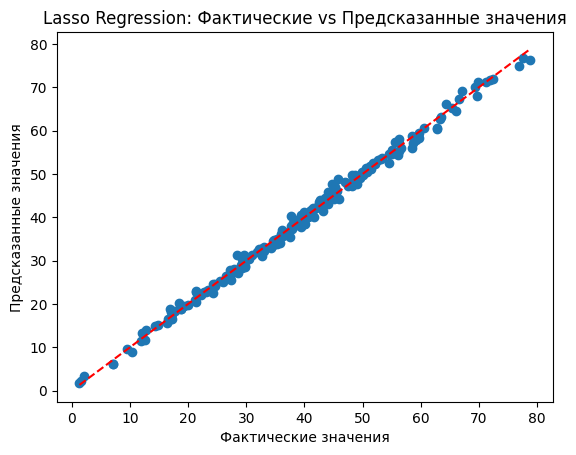

Прогнозы на новых данных:
[51.22618692 46.46832889 16.46801194 35.86381898 56.65454999 35.73581909
 48.4063496  43.40178822 46.64433934 36.15388007]


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Генерация данных
np.random.seed(42)
n_samples = 1000
n_features = 5

X = np.random.rand(n_samples, n_features) * 10
true_coef = np.array([5, 0, 3, 0, 0])  # Предполагаемые веса признаков
y = X.dot(true_coef) + np.random.normal(size=n_samples)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Оценка модели на тестовом наборе данных
score = lasso.score(X_test_scaled, y_test)
coefficients = lasso.coef_

print("Score (R^2):", score)
print("Веса признаков:", coefficients)

# Предсказания модели на тестовом наборе данных
y_pred = lasso.predict(X_test_scaled)

# Визуализация фактических значений и предсказаний
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Lasso Regression: Фактические vs Предсказанные значения")
plt.show()

# Генерация новых данных для тестирования
X_new = np.random.rand(10, n_features) * 10

# Масштабирование новых данных
X_new_scaled = scaler.transform(X_new)

# Прогнозирование на новых данных
predictions_new = lasso.predict(X_new_scaled)

print("Прогнозы на новых данных:")
print(predictions_new)

2. Пример **Ridge Regression**:

Рассмотрим задачу прогнозирования стоимости медицинского оборудования на основе различных характеристик, таких как производительность, технические характеристики и т.д. В этом случае Ridge Regression может быть применена для борьбы с мультиколлинеарностью и ограничениями на величину весов, что поможет улучшить обобщающую способность модели.

Score (R^2): 0.989710465903315
Веса признаков: [ 8.92127472  2.93043154  5.59536262 -0.0390238  -0.01138905]


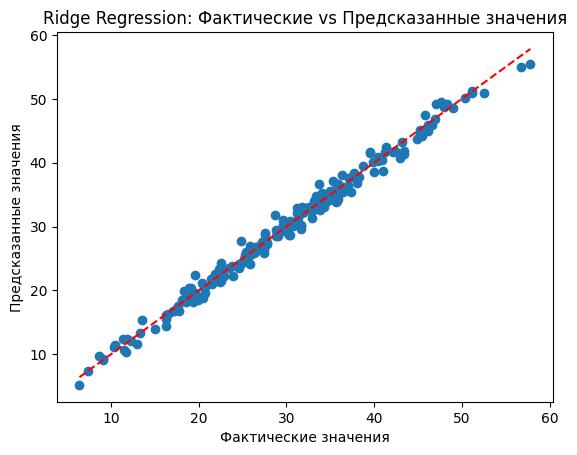

Прогнозы на новых данных:
[19.10533196 23.04381159 34.04855459 31.49406408 49.08789325 15.74189422
 29.83987098 32.34561305 28.34485748 24.29099881]


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Генерация данных
np.random.seed(42)
n_samples = 1000
n_features = 5

X = np.random.rand(n_samples, n_features) * 10
true_coef = np.array([3, 1, 2, 0, 0])  # Предполагаемые веса признаков
y = X.dot(true_coef) + np.random.normal(size=n_samples)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# Оценка модели на тестовом наборе данных
score = ridge.score(X_test_scaled, y_test)
coefficients = ridge.coef_

print("Score (R^2):", score)
print("Веса признаков:", coefficients)

# Предсказания модели на тестовом наборе данных
y_pred = ridge.predict(X_test_scaled)

# Визуализация фактических значений и предсказаний
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Ridge Regression: Фактические vs Предсказанные значения")
plt.show()

# Генерация новых данных для тестирования
X_new = np.random.rand(10, n_features) * 10

# Масштабирование новых данных
X_new_scaled = scaler.transform(X_new)

# Прогнозирование на новых данных
predictions_new = ridge.predict(X_new_scaled)

print("Прогнозы на новых данных:")
print(predictions_new)

# Литература
* https://link.springer.com/chapter/10.1007/978-3-030-95860-2_3

* https://datatalks.club/blog/regularization-in-regression.html

* https://github.com/alexeygrigorev/mlbookcamp-code/tree/master
